# Computational Intelligence
# Lab: Genetic Programming (GP)

## Outline
1. Symbolic regression:
  - `TestCase` class
  - `Function` class
  - `TestCaseGenerator` class
2. Linear program: representation and execution
  - `Instruction` class
  - `Individual` class
  - `Population` class
  - `Evaluator` class
3. Reproduction-related classes
  - `Selection` class
  - `Crossover` class
  - `Mutation` class
  - `Breeder` class
4. Linear genetic programming
  - `ParameterSet` class
  - `LGP` class

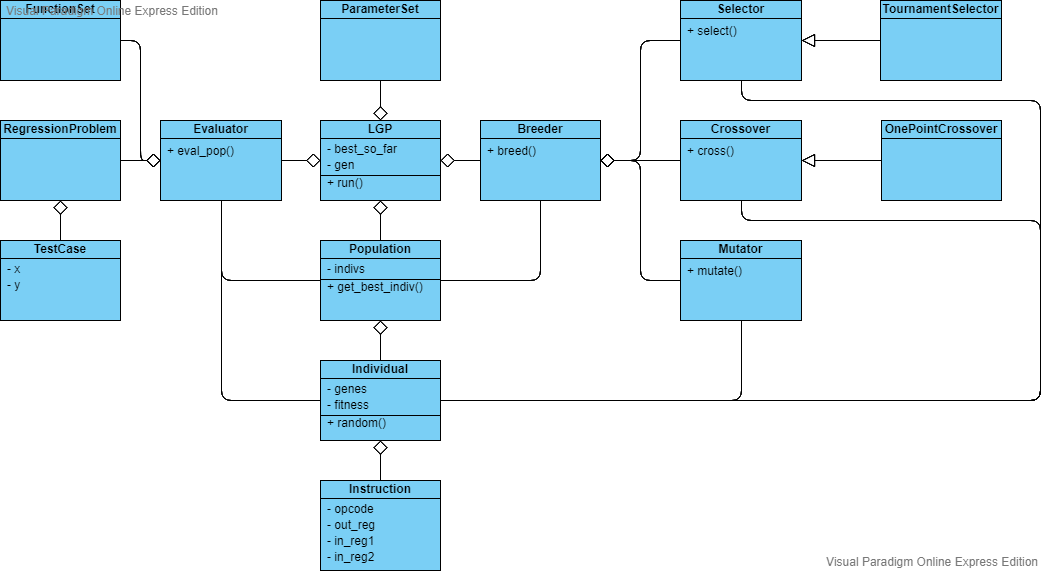

## 1. Symbolic regression

## The `TestCase` class

In [ ]:
class TestCase:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return "x: " + str(self.x) + ", y: " + str(self.y)

In [ ]:
tc1 = TestCase(10, 1)
tc2 = TestCase([1, 2, 5], 0.2)

print(tc1)
print(tc2)

## The `Function` class

In [ ]:
# ----------------------------
# Base class: Function
# ----------------------------
class Function:
    def __init__(self):
        self.fn = "20 * np.sin(x[0]) + 10 * np.cos(x[1]) - 0.5 * x[0] * x[1]"   # Function (represetned as a string)
        self.domain = [[-3.0, 3.0], [3.0, 5.0]]
    
    def evaluate(self, x):
        return eval(self.fn)            # Convert string into expression and evaluate
    
    def get_num_var(self):
        return len(self.domain)
    
    def print(self):
        print("--------------------------")
        print("Function:", self.fn)
        print("Number of variables:", self.get_num_var())
        print("Domain:", self.domain)
        print("--------------------------")
        
    def __str__(self):
        return self.fn.replace("np.", "") # To remove "np."

# ----------------------------
# Derived class: Simple1DFunction
# ----------------------------
class TestFunction1D(Function):
    def __init__(self):
        #self.fn = "np.sin(20 * np.pi * x) + np.cos(6 * np.pi * x)"
        #self.domain = [[-.5, .5]]
        self.fn = "x * x - x + 1"
        self.domain = [[-10, 10]]

## The `TestCaseGenerator` class

In [ ]:
import numpy as np
class TestCaseGenerator:
    def __init__(self, fn):
        self.fn = fn
        
    def generate(self, num_test_cases):
        test_case_list = []
        for i in range(num_test_cases):
            x, y = self._gen_a_test_case()
            test_case_list.append(TestCase(x, y))
        return test_case_list
    
    def _gen_a_test_case(self):
        num_vars = self.fn.get_num_var()
        x = np.zeros(num_vars)
        for i in range(len(x)):
            x[i] = np.random.uniform(self.fn.domain[i][0], self.fn.domain[i][1])
        y = self.fn.evaluate(x)
        return x, y

In [ ]:
gen = TestCaseGenerator(fn=TestFunction1D())
test_cases = gen.generate(300)
for tc in test_cases:
    print(tc)
    
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)

## 2. Linear program: representation and execution

In [ ]:
import numpy as np

## The `Instruction` class

In [ ]:
LARGEST_RAND    = 100

class Instruction:
    def __init__(self, code=None):
        if code == None:
            self.random()
        else:
            self.set(code)
            
    def set(self, code):
        self.opcode = code[0]
        self.out_reg = code[1]
        self.in_reg1, self.in_reg2 = code[2], code[3]
        
    def random(self):
        self.set(np.random.randint(LARGEST_RAND, size=4))
        
    def __str__(self):
        return "[" + str(self.opcode) + " " + str(self.out_reg) + " " + \
               str(self.in_reg1) + " " + str(self.in_reg2) + "]"

In [ ]:
instr1 = Instruction([13, 2, 4, 5])
print(instr1.opcode)
print(instr1.out_reg)
print(instr1.in_reg1)
print(instr1.in_reg2)
print(instr1)

## The `Individual` class

In [ ]:
DEFAULT_FITNESS = 0

class Individual:
    def __init__(self, num_instrs):
        self.genes = [Instruction() for i in range(num_instrs)]
        self.fitness = DEFAULT_FITNESS
        self.random()

    def get_length(self):
        return len(self.genes)
        
    def random(self):
        for i in range(self.get_length()):
            self.genes[i].random()
        
    def is_better_than(self, other):
        return self.fitness > other.fitness # Suppose "the larger fitness, the better individual" is true.
        
    def __str__(self):
        return "gene = " + "".join(str(g) for g in self.genes) + ", fit = " + str(format(self.fitness, "10.4f"))

In [ ]:
indiv = Individual(5)
indiv.fitness = 10
print(indiv)

## The `Population` class

In [ ]:
class Population:
    def __init__(self, size, num_instrs):
        self.indivs = [Individual(num_instrs) for i in range(size)]

    def get_pop_size(self):
        return len(self.indivs)

    def get_best_indiv(self):
        best = self.indivs[0]
        for i in self.indivs:
            if i.is_better_than(best):
                best = i
        return best

    def print(self):
        for p in self.indivs:
            print(p)

In [ ]:
pop = Population(10, 5)
pop.indivs[3].fitness = 5
pop.indivs[6].fitness = 7
pop.indivs[8].fitness = -10
pop.print()

print("Best", pop.get_best_indiv())

## The `Evaluator` class

In [ ]:
num_test_cases = 100
test_cases = gen.generate(num_test_cases)

from math import sin, cos
primitives = [["ADD", "reg[out] = reg[in1] + reg[in2]"], \
              ["SUB", "reg[out] = reg[in1] - reg[in2]"], \
              ["MUL", "reg[out] = reg[in1] * reg[in2]"], \
              ["DIV", "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]"], \
              ["SIN", "reg[out] = sin(reg[in1])"], \
              ["COS", "reg[out] = cos(reg[in1])"]]

# primitives = {"ADD" : "reg[out] = reg[in1] + reg[in2]", \
#               "SUB" : "reg[out] = reg[in1] - reg[in2]", \
#               "MUL" : "reg[out] = reg[in1] * reg[in2]", \
#               "DIV" : "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]", \
#               "SIN" : "reg[out] = sin(reg[in1])", \
#               "COS" : "reg[out] = cos(reg[in1])"}

num_regs = 8
registers = np.zeros(num_regs)

In [ ]:
class Evaluator:
    def __init__(self, primitives, test_cases, num_regs):
        #self.params = params
        self.num_regs = num_regs
        self.registers = np.zeros(self.num_regs)
        self.primitives = primitives
        self.num_primitives = len(primitives)
        
    def eval_pop(self, pop):
        for indiv in pop.indivs:
            x, f = self.eval_indiv(indiv)

    def eval_indiv(self, indiv):
        sum_sq_err = 0.0
        for tc in test_cases:
            y = self._execute(indiv.genes, tc.x)
            sum_sq_err += (tc.y - y) ** 2 
        #indiv.fitness = float(-sum_sq_err / len(test_cases))
        indiv.fitness = float(-sum_sq_err)
        return x, indiv.fitness
    
    def decode_indiv(self, indiv):
        program = ""
        for instr in indiv.genes:
            opcode, out, in1, in2 = self._decode_instr(instr)
            line = (primitives[opcode][1] + "\n")
            line = line.replace("out", str(out))
            line = line.replace("in1", str(in1))
            line = line.replace("in2", str(in2))
            program += line
        return program
    
    def _execute(self, genes, x):
        self._reset_reg(x)
        reg = self.registers
        for instr in genes:
            opcode, out, in1, in2 = self._decode_instr(instr)
            exec(self.primitives[opcode][1])
        return reg[0]
    
    def _reset_reg(self, x):
        for i in range(len(self.registers)):
            self.registers[i] = 1
        for i in range(len(x)):
            self.registers[i] = x[i]
    
    def _decode_instr(self, instr):
        instr.opcode %= self.num_primitives
        instr.out_reg %= self.num_regs
        instr.in_reg1 %= self.num_regs
        instr.in_reg2 %= self.num_regs
        return instr.opcode, instr.out_reg, instr.in_reg1, instr.in_reg2

In [ ]:
evl = Evaluator(primitives, test_cases, num_regs)
evl.eval_pop(pop)
pop.print()

print("Best", pop.get_best_indiv())

In [ ]:
program = evl.decode_indiv(pop.indivs[2])
print(program)

reg = np.ones(num_regs)
x = 3
reg[0] = x
exec(program)
y = reg[0]
print("x = %d, y = %d" % (x, y))

## 3. Reproduction-related classes

## The `Selector` class and `TournametSelector` class


In [ ]:
import random
# ----------------------------
# Base class: Selector
# ----------------------------
class Selector:
    def select(self, pop):                  # Just random selection
        size = pop.get_pop_size()
        rd = random.randint(0, size - 1)
        return pop.indivs[rd]

# ----------------------------
# Derived class: TournamentSelector
# ----------------------------
class TournamentSelector(Selector):
    def __init__(self, tournament_size):
        super().__init__()
        self.ts = tournament_size

    def select(self, pop):
        size = pop.get_pop_size()
        rd = random.randint(0, size - 1)
        best_idx = rd;
        
        for i in range(1, self.ts):
            rd = random.randint(0, size - 1)
            if pop.indivs[rd].is_better_than(pop.indivs[best_idx]):
                best_idx = rd;

        return pop.indivs[best_idx]
#----------------------------

## The `Crossover` class and `OnePointCrossover` class
- Simulate a breeding process
- That is, mixing DNAs of two parents to generate (usually two) offspring

In [ ]:
import random
# ----------------------------
# Base class: Crossover
# ----------------------------
class Crossover:
    def __init__(self, pc):
        self.pc = pc

# ----------------------------
# Derived class: OnePointCrossover
# ----------------------------
class OnePointCrossover(Crossover):
    def __init__(self, pc):
        super().__init__(pc)

    def cross(self, p1, p2):
        rd = random.uniform(0, 1)
        if(rd < self.pc):
            cut_point = random.randint(1, p1.get_length() - 1)
            #print("cutPoint = ", cutPoint)
            p1.genes[cut_point:], p2.genes[cut_point:] = p2.genes[cut_point:], p1.genes[cut_point:]
        return p1, p2  

## The `Mutator` class
- For each instruction in the gene, generate a random number $rd \in [0, 1]$
- If the random number $rd$ is smaller than the mutation probability $p_m$, modify that instruction.
  - Replaced that instructio by a random instruction

In [ ]:
# ----------------------------
# Base class: Mutator
# ----------------------------
class Mutator:
    def __init__(self, pm):
        self.pm = pm
        
    def mutate(self, p):
        for i in range(p.get_length()):
            rd = random.uniform(0,1)
            if rd < self.pm:
                p.genes[i].random()
        return p

## The `Breeder` class

In [ ]:
from copy import deepcopy
class Breeder:
    def __init__(self, selector, crossover, mutator, elitism):
        self.selector = selector
        self.crossover = crossover
        self.mutator = mutator
        self.elitism = elitism

    def breed(self, parent_pop, offspring_pop):
        size = parent_pop.get_pop_size()

        count = 0
        while count < size:
            #selection
            p1 = deepcopy(self.selector.select(parent_pop))
            p2 = deepcopy(self.selector.select(parent_pop))
            
            #crossover
            q1, q2 = self.crossover.cross(p1, p2)
            
            #mutation
            o1 = self.mutator.mutate(q1)
            o2 = self.mutator.mutate(q2)
            
            #insert new individuals into the offspring popuation
            offspring_pop.indivs[count] = o1
            count += 1
            offspring_pop.indivs[count] = o2
            count += 1

        #elitist
        if self.elitism is True:
            offspring_pop.indivs[0] = deepcopy(parent_pop.get_best_indiv())

## 4. Linear genetic programming

## The `ParameterSet` class

In [ ]:
class ParameterSet:
    def __init__(self):         # Assign default parameters (can be changed after an object is created)
        # Problem-related parameters
        self.is_maximize = True # Maximization problem or minimization problem
        
        # GA's parameters
        self.max_gen  = 20      # Maximum number of generations
        self.pop_size = 20      # Population size
        
        # Individual-related parameters
        self.num_instrs = 10

        # Evaluator-related parameters
        self.num_regs = 8
        
        # Breeder-related parameters
        self.ts = 2             # Tournament size
        self.pc = 0.9           # Crossover rate
        self.pm = 0.1           # Mutation rate
        self.elitism = True     # Elitism
        
    def print(self):
        print("--------------------------")
        print("Parameter Setting:")
        if self.is_maximize is True:
            print("Problem: Maximization")
        else:
            print("Problem: Minimization")
        print("Maximum number of generations =", self.max_gen)
        print("Population size =", self.pop_size)
        print("Number of instructions (fixed) =", self.num_instrs)
        print("Number of registers =", self.num_regs)
        print("Tournament size =", self.ts)
        print("Crossover rate =", self.pc)
        print("Mutation rate =", self.pm)
        print("Elitism =", self.elitism)
        print("--------------------------")

## The `LGP` class

In [ ]:
import time

class LGP:
    def __init__(self, primitives, test_cases, params=ParameterSet()):
        # Create evaluator
        self.evaluator = Evaluator(primitives, test_cases, params.num_regs)

        # Parameter settings
        self.params = params
    
        # Create breeder
        selector = TournamentSelector(params.ts)
        crossover = OnePointCrossover(params.pc)
        mutator = Mutator(params.pm)
        self.breeder = Breeder(selector, crossover, mutator, params.elitism)
       
    def _reset(self):
        self.gen = 0
        self.best_so_far = None
        self.pop1 = Population(self.params.pop_size, self.params.num_instrs)
        self.pop2 = Population(self.params.pop_size, self.params.num_instrs)

    def _update_best_so_far(self, pop):
        current_best = pop.get_best_indiv()
        if self.best_so_far == None:
            self.best_so_far = deepcopy(current_best)
        elif current_best.is_better_than(self.best_so_far):
            self.best_so_far = deepcopy(current_best)

    def run(self):
        # Reset state
        self._reset()

        # Loop
        for self.gen in range(self.params.max_gen):
            # Evaluate current population
            self.evaluator.eval_pop(self.pop1)
            print("--------------------------")
            print("Generation:", self.gen)
            self.pop1.print()

            # Check best-so-far individual
            self._update_best_so_far(self.pop1)         
            print("Best-so-far:", self.best_so_far)
            
            # Breed offspring population
            self.breeder.breed(self.pop1, self.pop2)

            # Swap population
            self.pop1, self.pop2 = self.pop2, self.pop1

            # Delay
            time.sleep(0.5)
            
        return self.best_so_far

## Test the `LGP` class

In [ ]:
# Create a set of parameters
params = ParameterSet()
# Adjust some parameters
params.is_maximize = True
params.max_gen = 30
params.pop_size = 20
params.num_regs = 4
params.num_instrs = 8
# Verify parameters
params.print()

In [ ]:
from math import sin, cos

primitives = [["ADD", "reg[out] = reg[in1] + reg[in2]"], \
              ["SUB", "reg[out] = reg[in1] - reg[in2]"], \
              ["MUL", "reg[out] = reg[in1] * reg[in2]"], \
              ["DIV", "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]"], \
              ["SIN", "reg[out] = sin(reg[in1])"], \
              ["COS", "reg[out] = cos(reg[in1])"]]

gen = TestCaseGenerator(fn=TestFunction1D())
num_test_cases = 300
test_cases = gen.generate(num_test_cases)
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)

In [ ]:
# Create an LGP object
lgp = LGP(primitives, test_cases, params)

# Then, run GA
best_indiv = lgp.run()

In [ ]:
# Display result
print("\nThe best individual founded by GP:", best_indiv)

print("\nSolution:")
program = lgp.evaluator.decode_indiv(best_indiv)
print(program)

r = []
for tc in test_cases:
    result = lgp.evaluator._execute(best_indiv.genes, tc.x)
    r.append(result)
    
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)
plt.scatter(x, r)

In [ ]:
# Before execution
# reg[0] = x
# reg[1:] = 1

if reg[1] == 0: # False
    reg[3] = 1
else:
    reg[3] = reg[0] / reg[1]    # reg[3] <- x

reg[0] = reg[2] - reg[0]        # reg[x] <- 1 -x

# reg[1] = reg[2] - reg[3]

# reg[1] = cos(reg[3])

reg[2] = reg[3] * reg[3]        # reg[2] <- x * x

# if reg[0] == 0:
#     reg[1] = 1
# else:
#     reg[1] = reg[2] / reg[0]
    
# if reg[0] == 0:
#     reg[1] = 1
# else:
#     reg[1] = reg[3] / reg[0]
    
reg[0] = reg[0] + reg[2]        # reg[0] <- 1 - x + x * x

In [ ]:
reg[3] = reg[0] / reg[1]  # reg[3] = x / 1 = x
reg[0] = reg[2] - reg[0]  # reg[0] = 1 - x
reg[2] = reg[3] * reg[3]  # reg[2] = x * x
reg[0] = reg[0] + reg[2]  # reg[0] = (1 - x) + (x * x) = x * x - x + 1